(example_4)=
# Example 4: Causal discovery in a predictive coding network

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_3_Multi_armed_bandit.ipynb)

```{admonition} Authors
:class: tip

- Lina Walkowiak, Aarhus University, Denmark ([202205493@post.au.dk](202205493@post.au.dk))
- Nicolas Legrand, Aarhus University, Denmark ([nicolas.legrand@cas.au.dk](nicolas.legrand@cas.au.dk))
```

In [1145]:
import sys

from IPython.utils import io

if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [1146]:
%load_ext autoreload
%autoreload 2

from functools import partial
from typing import Callable, Dict, NamedTuple, Optional, Tuple

import jax
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from jax import Array, jit
from sklearn.metrics import mutual_info_score
from matplotlib import rcParams

from pyhgf import load_data
from pyhgf.math import gaussian_surprise, sigmoid, gaussian_density
from pyhgf.response import first_level_gaussian_surprise
from pyhgf.model.network import Network
from pyhgf.typing import Edges
from pyhgf.utils import beliefs_propagation
from pyhgf.updates.prediction_error.continuous import continuous_node_prediction_error
from pyhgf.updates.posterior.continuous import continuous_node_posterior_update
from pyhgf.updates.prediction.continuous import continuous_node_prediction


np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction

In this notebook, we are interested in embedding dynamic causal discovery in predictive coding networks. Generalised hierarchical Gaussian filters are Bayesian models. As such, they imply a portion of causality in the framework: a parent node can exert a causal influence on a child node. The strength of this causal influence is controlled by `*_couplings_*` parameters in the network's attributes.

This is in a situation where the parent is updated by the prediction errors returned by the children. But causality can also be inferred from variables that remain independent during the learning process - therefore the cause should not be updated based on a change in the effect. This corresponds to a causal discovery principle, and we can define $ \alpha_{1 \rightarrow 2} \in [0, 1]$ the *causal strength* that describes how much a variable $X_1$ is influencing another variable $X_2$. In this tutorial, we describe how this variable can be learned online.

## Data simulation

We create two synthetic time series, $x_1$ and  $x_2$, where $x_1$ influences $x_2$ with varying intensities $\alpha_{1 \rightarrow 2} \in [0, 1]$ over time. Both random variables are defined as Gaussian random walks such as: 

$$
\begin{align*} 
    X_1 & \sim \mathcal{N}(\mu_1, \sigma_1^2) \\
    X_2 & \sim \mathcal{N}(\mu_2, \sigma_2^2) \\
\end{align*} 
$$

We can explicitly inform this model that $X_1$ influences $X_2$ from one time step to the next proportionally to a coupling strength, such as:

$$
\begin{align*} 
    X_2 = \alpha X_1 + X_2 \\
\end{align*} 
$$

Were we have:

$$
\begin{align*} 
    X_2 & \sim \mathcal{N}(\alpha \mu_1 + \mu_2, \alpha^2 \sigma_1^2 + \sigma_2^2) \\
\end{align*} 
$$

We simulate below an example of a time series:

In [1147]:
# Parameters
n_samples = 1000

# Generate x_1 and x_2 as a random walk
x1 = np.ones(n_samples) * 2
x2 = np.zeros(n_samples)

# Coupling vector
coupling = np.array([0.0, 0.0, 0.2, 0.2, 0.8, .8, 0.5, 0.5, 0.5, 0.5]).repeat(
    n_samples / 10
)

# Update x_2 so it is influenced by x_1 according to the coupling vector
for i in range(1, n_samples):
    x2[i] = np.random.normal(x2[i-1] + coupling[i] * x1[i-1], .1)

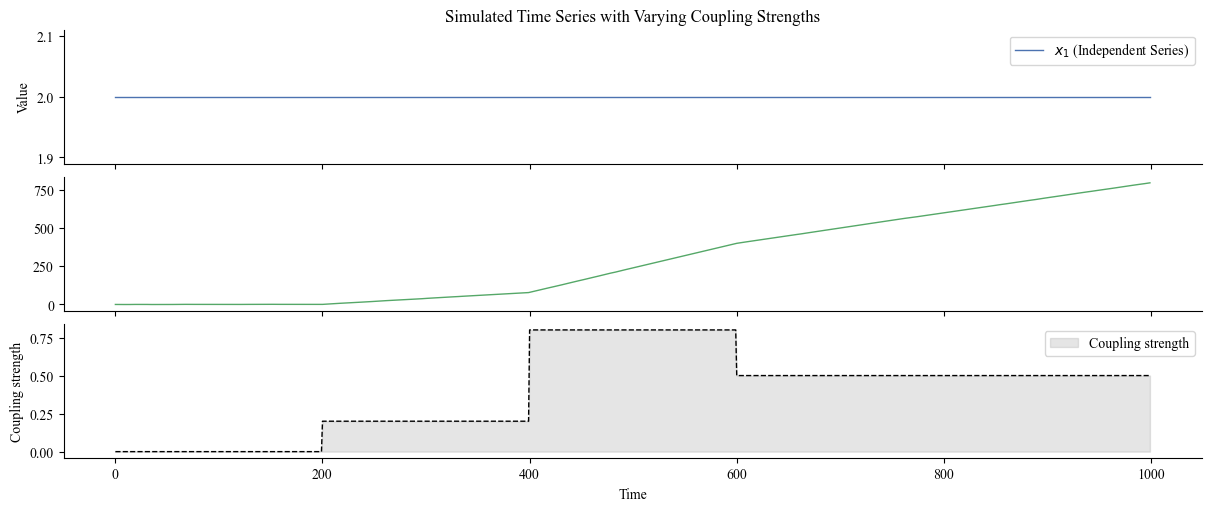

In [1148]:
# Plot
_, axs = plt.subplots(figsize=(12, 5), nrows=3, sharex=True)
axs[0].plot(x1, label=r"$x_1$ (Independent Series)", color="#4c72b0", linewidth=1)
axs[1].plot(x2, label="x2 (Dependent Series)", color="#55a868", linewidth=1)
axs[0].set(
    title="Simulated Time Series with Varying Coupling Strengths", ylabel="Value"
)
axs[0].legend()

axs[2].plot(coupling, color="k", linestyle="--", linewidth=1.0)
axs[2].fill_between(
    np.arange(0, len(coupling)),
    coupling,
    color="gray",
    alpha=0.2,
    label="Coupling strength",
)
axs[2].set(xlabel="Time", ylabel="Coupling strength")
axs[2].legend()
sns.despine();

## A non-causal network

We can filter these streams of observation using a simple one-level model without assuming dependencies between the parent nodes or the variables.

In [1149]:
# Initialize two independent HGFs for X1 and X2
non_causal_hgf = (
    Network()
    .add_nodes(precision=100.0)
    .add_nodes(precision=1.0)
    .add_nodes(value_children=0, mean=2.0)
    .add_nodes(value_children=1, tonic_volatility=5.0)
)

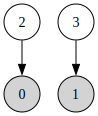

In [1150]:
non_causal_hgf.plot_network()

In [1151]:
# Input the time series
input_data = np.array([x1, x2]).T
non_causal_hgf.input_data(input_data=input_data);

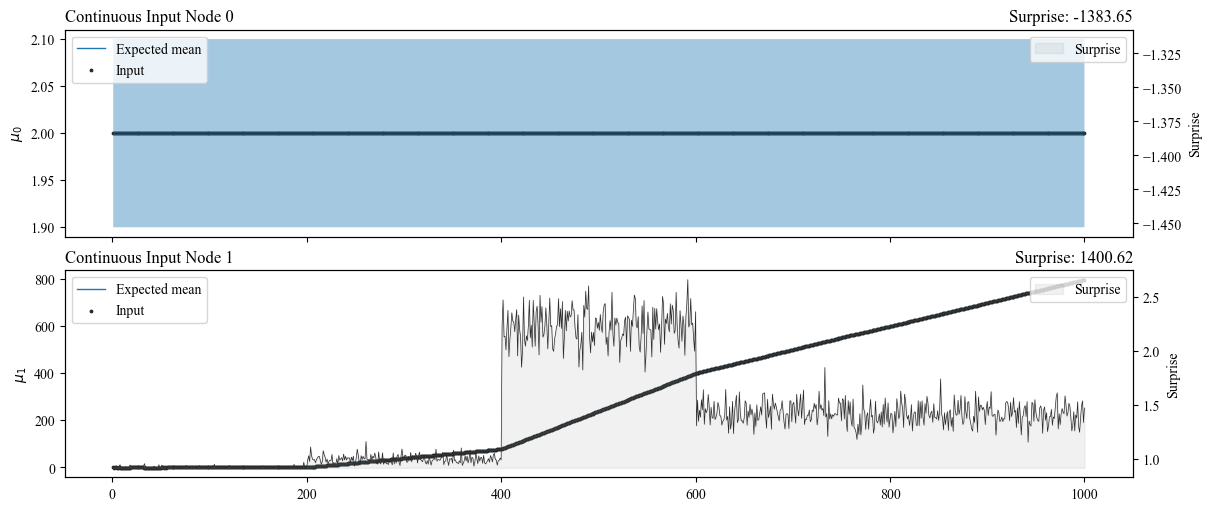

In [1152]:
# Plot trajectories for each HGF
non_causal_hgf.plot_nodes(node_idxs=[0, 1]);

## Deriving prediction errors around the causal strength

We can also assume that both input nodes try to discover their causal dependencies over time by trying to contribute the the prediction of the other node and learning from their error in doing so. Given a new observation $u_1$, received by the node $1$, we can define a precision-weighted prediction errors $\delta_1$ for the non-causal hypothesis, where node $1$ only use its expectation to predict new incoming values$:

$$
\begin{align*} 
    \delta_1 & = (u - \mu_2) \cdot \frac{1}{\sigma_2^2} \\
\end{align*} 
$$

And we can also define a second prediction error $\delta_{0 \rightarrow 1}$ for the causal hypothesis, this time assuming that $X_1$ is added to $X_2$ proportionally to a coupling strength $\alpha$:

$$
\begin{align*} 
    \delta_{0 \rightarrow 1} & = (u - \mu_2 - \alpha \mu_1) \cdot \frac{1}{\alpha^2 \sigma_1^2 + \sigma_2^2} \\
\end{align*} 
$$

Let $f(\alpha)$ denote the squared precision-weigthed prediction error when assuming a given $\alpha$ as:

$$
f(\alpha) = (u - \mu_2 - \alpha \mu_1)^2 \cdot \frac{1}{\alpha^2 \sigma_1^2 + \sigma_2^2}
$$

This function has a first derivative defined as:

$$
f'(\alpha) = -\frac{2 \left({\mu}_{1} x + {\mu}_{2} - u\right) \left(\left({\mu}_{2} - y\right) {\sigma}_{1}^2 x - {\mu}_{1} {\sigma}_{2}\right)}{\left({\sigma}_{1}^2 x^{2} + {\sigma}_{2}^2\right)^{2}}
$$

Two roots can be found at:

$$
\begin{align*} 
\hat{\alpha}_1 & = -\frac{{\mu}_{2} - u}{{\mu}_{1}} \\
\\
\hat{\alpha}_2 & = \frac{{\mu}_{1} {\sigma}_{2}^2}{\left({\mu}_{2} - u\right) {\sigma}_{1}^2}
\end{align*} 
$$

It is therefore possible to recover the implied parameter $\hat{\alpha}$ over the range $[0, 1]$ by returning $\alpha \in [0.0, \hat{\alpha}_1, \hat{\alpha}_2, 1.0]$ such that $0.0 <= \alpha <= 1.0$ that minimize the precision-weigthed prediction error $f(\alpha)$.

## Causal coupling model

In this section, we create a coupled HGF model to capture the causal influence of the variable $x_1$ on the variable $x_2$. This setup now implies learning the strength of a causal connection between $x_1$ and $x_2$, which should reflect the actual value used for the simulations above. We therefore use the same model as a starting point and will add an extra step in the update sequence to learn the causal coupling strength over time.

In [1153]:
# Initialize a causal HGF
causal_hgf = (
    Network()
    .add_nodes(precision=100.0)
    .add_nodes(precision=1.0)
    .add_nodes(value_children=0)
    .add_nodes(value_children=1, tonic_volatility=5.0)
)

### Add a causal connection between the two nodes

In [1154]:
# Add the coupling strength in the node attributes
causal_hgf.attributes[0]["causal_coupling_children"] = jnp.array([0.0])

In [1155]:
# Update the edges variable so it stores the index of the causal child
edges = list(causal_hgf.edges)
adjacency_list = edges[0]

In [1156]:
# Create a new adjacency variable for this case
class CausalAdjacencyLists(NamedTuple):
    node_type: int
    value_parents: Optional[Tuple]
    volatility_parents: Optional[Tuple]
    value_children: Optional[Tuple]
    volatility_children: Optional[Tuple]
    coupling_fn: Tuple[Optional[Callable], ...]
    causal_children: Optional[Tuple]


causal_adjacency_list = CausalAdjacencyLists(
    node_type=adjacency_list.node_type,
    value_parents=adjacency_list.value_parents,
    volatility_parents=adjacency_list.volatility_parents,
    value_children=adjacency_list.value_children,
    volatility_children=adjacency_list.volatility_children,
    coupling_fn=adjacency_list.coupling_fn,
    causal_children=(1,),
)

In [1157]:
# Insert the new variable back to the edges
edges[0] = causal_adjacency_list
causal_hgf.edges = tuple(edges)

### Create the causal update function

Now that the variables are in place in the network, we need to create a new update function that will estimate the causal strength between the two variables at each belief propagation.

In [1158]:
def prediction_error(u, alpha, mu_1, mu_2, var_1, var_2):
    return (u - mu_2 - alpha * mu_1)**2 * (1 / (alpha**2 * var_1 + var_2 ) )

In [1159]:
def find_alpha(u, mu_1, mu_2, var_1, var_2):

    # find root 1
    alpha_hat_1 = jnp.where(mu_1 == 0.0, 0.0, - (mu_2 - u) / mu_1)

    # find root 2
    alpha_hat_2 = jnp.where((mu_2 - u) == 0.0, 0.0, (mu_1 * var_2) / ((mu_2 - u) * var_1))

    # evaluate at 0, 1 and the two possible roots
    candidates = jnp.array([0.0, alpha_hat_1, alpha_hat_2, 1.0])
    candidates = jnp.where((candidates >= 0.0) & (candidates <= 1.0), candidates, 0.0)

    pe = prediction_error(u, candidates, mu_1, mu_2, var_1, var_2)
    
    return candidates[jnp.argmin(pe)]

In [1160]:
@partial(jit, static_argnames=("node_idx", "edges"))
def continuous_node_causal_strength(
    attributes: Dict,
    edges: Edges,
    node_idx: int,
) -> Array:
    r"""Update the causal strength between this node and all causal children.

    Parameters
    ----------
    attributes :
        The attributes of the probabilistic nodes.
    node_idx :
        Pointer to the value parent node that will be updated.

    Returns
    -------
    attributes :
        The attributes of the probabilistic nodes.

    """
    # get the expected mean and precision from the causal parent
    parent_expected_mean = attributes[node_idx]["expected_mean"]
    parent_expected_precision = attributes[node_idx]["expected_precision"]

    # set a learning rate for the speed of updating
    learning_rate = 0.1

    # for all causal children, compute the new causal strength
    new_strengths = []
    for causal_child_idx, strength in zip(
        edges[node_idx].causal_children,
        attributes[node_idx]["causal_coupling_children"],
    ):

        # get children's expected mean and precision
        child_expected_mean = attributes[causal_child_idx]["expected_mean"]
        child_expected_precision = attributes[causal_child_idx]["expected_precision"]

        # get a new estimate of alpha
        new_alpha = find_alpha(
            u=attributes[causal_child_idx]["mean"], 
            mu_1=parent_expected_mean,
            mu_2=child_expected_mean, 
            var_1=1 / parent_expected_precision, 
            var_2=1 / child_expected_precision,
        )

        new_strengths.append(strength + (new_alpha - strength) * learning_rate)

    # update the strengths vector
    attributes[node_idx]["causal_coupling_children"] = jnp.array(new_strengths)

    return attributes

In [1161]:
# Add this step at the end of the belief propagation sequence
# Here we simply re-use the previous sequence as template
predictions, updates = non_causal_hgf.update_sequence
updates += ((0, continuous_node_causal_strength),)
causal_hgf.update_sequence = (predictions, updates)
causal_hgf = causal_hgf.create_belief_propagation_fn()

## Fitting data and visualisation

In [1162]:
causal_hgf.input_data(input_data=input_data);

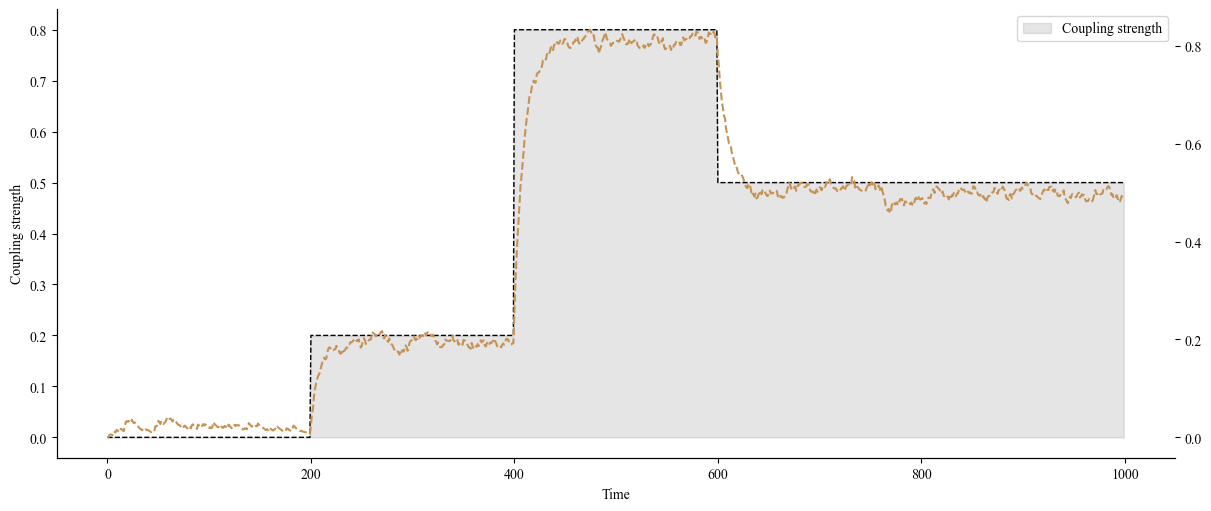

In [1163]:
# Plot
_, axs = plt.subplots(figsize=(12, 5), sharex=True)

axs.plot(coupling, color="k", linestyle="--", linewidth=1.0)
axs.fill_between(
    np.arange(0, len(coupling)),
    coupling,
    color="gray",
    alpha=0.2,
    label="Coupling strength",
)
axs.set(xlabel="Time", ylabel="Coupling strength")
axs.legend()

coupling_ax = axs.twinx()
coupling_ax.plot(
    causal_hgf.node_trajectories[0]["causal_coupling_children"],
    label="Inferred coupling strength",
    color="#c69255",
    linestyle="--",
)
sns.despine();

array([<Axes: title={'left': 'State Node 3'}, ylabel='$\\mu_{3}$'>,
       <Axes: title={'left': 'State Node 2'}, ylabel='$\\mu_{2}$'>,
       <Axes: title={'left': 'Continuous Input Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Continuous Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>],
      dtype=object)

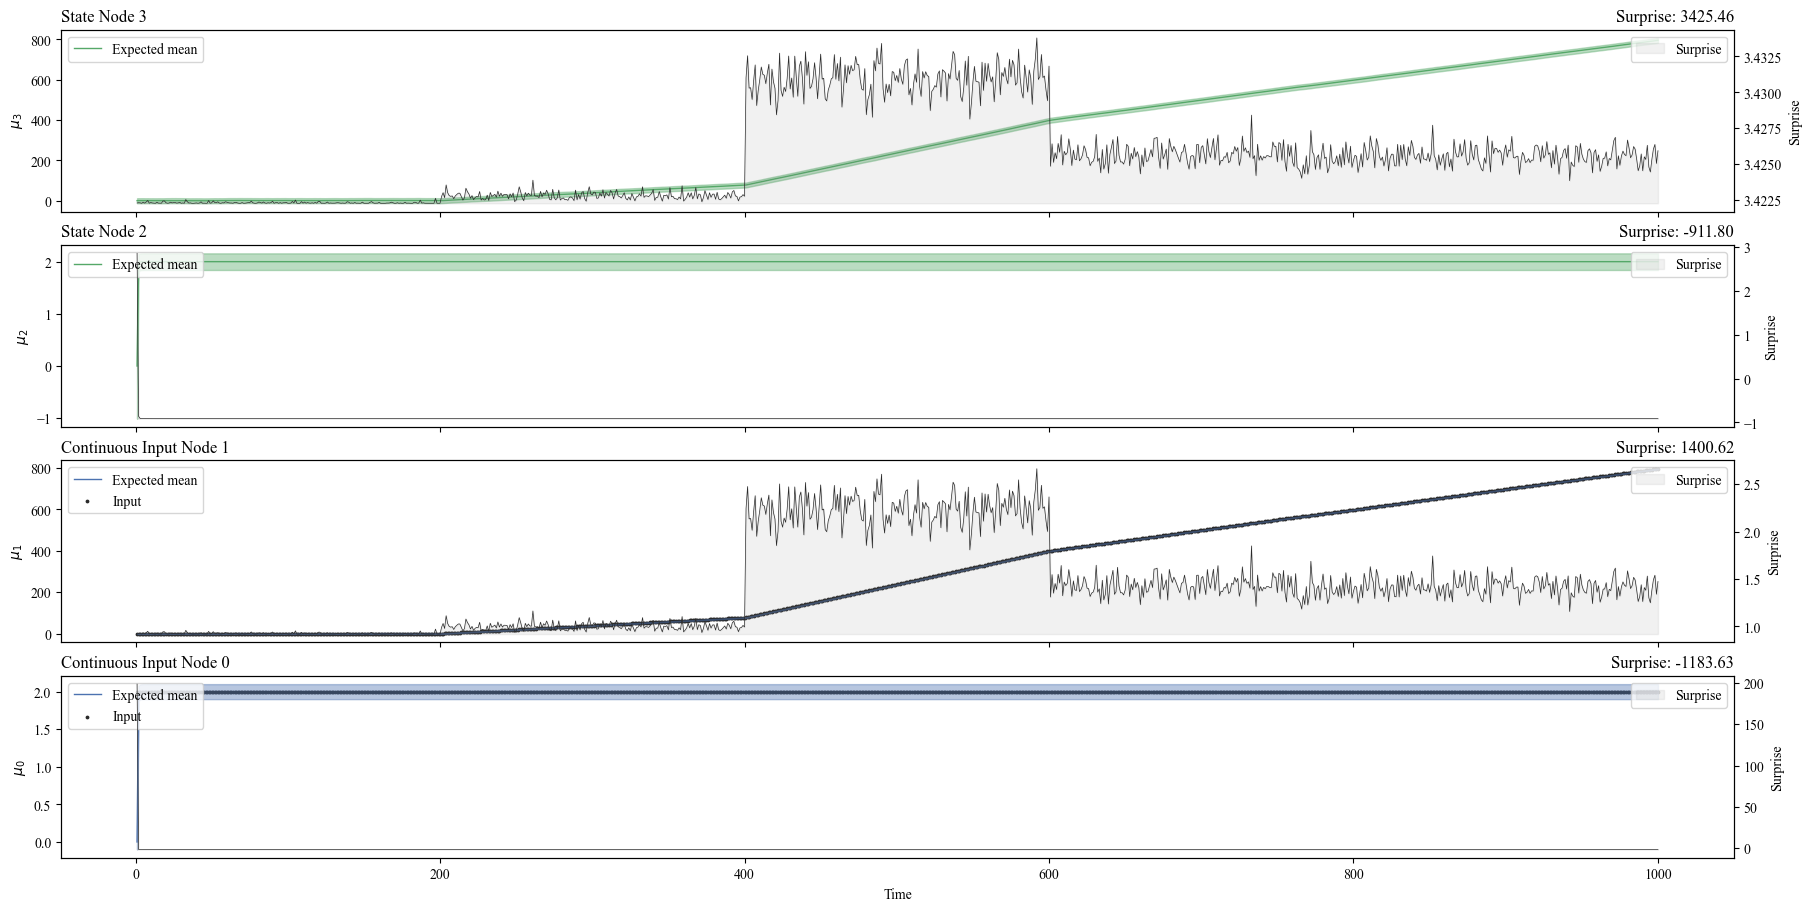

In [1164]:
causal_hgf.plot_trajectories()

# Simualtion: Optimal control in a simple ball-beam problem
We simulate agents that act in a dynamic environment, where the goal is to balance a variable (eg. a ball)) at 0, counteracting the randomly evolving position of it. Agents with and without causal discovery are simulated and we use the task performance and surprise as measures of their performance.

In [1165]:
def energy_saving_policy(expected_mean, causal_strength):
        threshold = 0.8
        if causal_strength > threshold:
            action = 0.0  # Save energy by not acting
        else:
            causal_strength = max(causal_strength, 1e-5)  
            action = -expected_mean / causal_strength
        return action

def predictive_causal_policy(expected_mean, causal_strength):
    # Ensure causal_strength is not too small to avoid instability
    causal_strength = max(causal_strength, 1e-5)
    raw_action = - (expected_mean / causal_strength)
    learning_rate=0.1
    previous_action = actions[-1]
    action = (1 - learning_rate) * previous_action - learning_rate * raw_action
    return action

     

def counterfactual_policy(expected_mean, causal_strength):
    # Previous observation and action
    previous_observation = observations[-1]
    previous_action = actions[-1]

    # Compute counterfactual observation without the previous action
    counterfactual_observation = previous_observation - previous_action * causal_influences[-1]

    # Compare deviations from 0
    actual_deviation = abs(previous_observation)
    counterfactual_deviation = abs(counterfactual_observation)

    # Check if the action was effective in reducing deviation from 0
    if counterfactual_deviation < actual_deviation:
        # Previous action did not help; don't act
        return 0.0
    else:
        # Act to maintain or improve the effect
        action = - expected_mean / causal_strength
        return action


## Non Causal HGF 
As a baseline, we use a noncausal HGF with two input nodes: One observing the agent's action, and one observing the position of the randomly evolving state. 

In [1166]:
# Define the continuous HGF
continuous_hgf = (
    Network()
    .add_nodes(precision = 500.0)
    .add_nodes(precision = 2.0) 
    .add_nodes(value_children=0)
    .add_nodes(value_children=1)
)
continuous_hgf.input_data(input_data=input_data);
continuous_hgf.create_belief_propagation_fn()



We define an array of variying causal influences taht are determining the extend to which the agent's action will influence the ball's position. This is what the causal agent is trying to infer. 

In [1167]:
# Define contingencies
causal_influences = np.array([0.0, 0.02, 0.05, 0.05, 0.08, 0.01, 0.02, 0.08, 0.0, 0.01]).repeat(
    n_samples/ 10)


# quickly and slowly changing 
stable_part = np.array([0.0, 0.2, 0.5, 0.8, 1.0]).repeat(n_samples / 10)
dynamic_part = np.array([0.0, 0.2, 0.5, 0.8, 1.0, 0.0, 0.2, 0.5, 0.8, 1.0]).repeat(n_samples / 20)


luences_shift = np.concatenate([stable_part, dynamic_part])
causal_influences_strong = np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0, 0.2, 0.8, 0.0, 1.0]).repeat(
    n_samples / 10)


# ball step size
low, medium_1, medium_2, medium_3, high = 0.5, 1.0, 2.0, 3.0, 5.0
stable = np.array([low, medium_1, medium_2, medium_3, high]).repeat(500/5)
volatile = np.tile(np.array([low, medium_1, medium_2, medium_3, high]).repeat(10), 10)
step_size = np.concatenate([stable, volatile])



In [1168]:
actions = []  # To store agent actions
observations = []  # To store continuous outcomes (sound intensity)
outcomes = [] 
node_0_expected_mean = []
node_1_expected_mean = []
node_2_expected_mean = []
node_3_expected_mean = []
node_0_precision = []
node_1_precision = []
node_2_precision = []
node_3_precision = []
node_0_prediction_error = []
node_1_prediction_error = []
node_2_prediction_error = []
node_3_prediction_error = []
surprise = []

# Get network information
attributes, edges, update_sequence = continuous_hgf.get_network()

for t in range(n_samples):

    # 1. Compute action using decision function
    if t == 0:
        action = 0
    else:
        # the position belief is taken as the basis for the action chosen
        expected_mean = attributes[1]['expected_mean']
        action = -expected_mean
    actions.append(action)

    # 2. Observe outcome
    if t == 0:  # First trial: random observation
        # The state eveolves as random walk
        outcome = np.random.normal(0, 0.5)
        observation = outcome  
    else:
        # state evolves based on previous state plus the randomness of the random walk
        causal_precision =  0.5 + (causal_influences[t]**2)*0.002
        outcome = observations[-1] + np.random.normal(0, causal_precision) 
        observation = outcome + action * causal_influences[t] 
        
    

    outcomes.append(outcome)
    observations.append(observation)

    # Prepare input for belief propagation
    action_input = action + np.random.normal(action, 0.002)
    input_data = np.array([action_input, observation])
    data = tuple(np.column_stack((input_data, np.ones(input_data.shape, dtype=int))).ravel())

    # Update the probabilistic network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        inputs=(*data, 1.0),
        update_sequence=update_sequence,
        edges=edges,
        input_idxs=continuous_hgf.input_idxs,
    )

    # Store metrics
    surprise_t = gaussian_surprise(
        x=attributes[1]["mean"],
        expected_mean=attributes[1]["expected_mean"],
        expected_precision=attributes[1]["expected_precision"],
    )
    surprise.append(surprise_t)

    # Store Node 0 metrics
    node_0_expected_mean.append(attributes[0]["expected_mean"])
    node_0_precision.append(attributes[0]["precision"])
    node_0_prediction_error.append(attributes[0]["temp"]["value_prediction_error"])

    # Store Node 1 metrics
    node_1_expected_mean.append(attributes[1]["expected_mean"])
    node_1_precision.append(attributes[1]["precision"])
    node_1_prediction_error.append(attributes[1]["temp"]["value_prediction_error"])

    # Store Node 2 metrics
    node_2_expected_mean.append(attributes[2]["expected_mean"])
    node_2_precision.append(attributes[2]["precision"])
    node_2_prediction_error.append(attributes[2]["temp"]["value_prediction_error"])

    # Store Node 3 metrics
    node_3_expected_mean.append(attributes[3]["expected_mean"])
    node_3_precision.append(attributes[3]["precision"])
    node_3_prediction_error.append(attributes[3]["temp"]["value_prediction_error"])

# Return results as a dictionary
non_causal_results = {
    "actions": np.array(actions),
    "observations": np.array(observations),
    "outcomes": np.array(outcomes),
    "node_0_expected_mean": np.asarray(node_0_expected_mean),
    "node_0_precision": np.asarray(node_0_precision),
    "node_0_prediction_error": np.asarray(node_0_prediction_error),
    "node_1_expected_mean": np.asarray(node_1_expected_mean),
    "node_1_precision": np.asarray(node_1_precision),
    "node_1_prediction_error": np.asarray(node_1_prediction_error),
    "node_2_expected_mean": np.asarray(node_2_expected_mean),
    "node_2_precision": np.asarray(node_2_precision),
    "node_2_prediction_error": np.asarray(node_2_prediction_error),
    "node_3_expected_mean": np.asarray(node_3_expected_mean),
    "node_3_precision": np.asarray(node_3_precision),
    "node_3_prediction_error": np.asarray(node_3_prediction_error),
    "surprise": np.array(surprise),
}


## Causal HGF: Inference of the causal action influence

In [1169]:
# Define the HGF causal network
hgf_causal = (
    Network()
    .add_nodes(precision = 500.0)
    .add_nodes(precision = 2.0) 
    .add_nodes(value_children=0)
    .add_nodes(value_children=1)
)

# Add causal coupling to Node 0
hgf_causal.attributes[0]["causal_coupling_children"] = jnp.array([0.0])  

# Update the edges variable so it stores the index of the causal child
edges = list(hgf_causal.edges)
adjacency_list = edges[0]

# Create a new adjacency variable for this case
class CausalAdjacencyLists(NamedTuple):
    node_type: int
    value_parents: Optional[Tuple]
    volatility_parents: Optional[Tuple]
    value_children: Optional[Tuple]
    volatility_children: Optional[Tuple]
    coupling_fn: Tuple[Optional[Callable], ...]
    causal_children: Optional[Tuple]


causal_adjacency_list = CausalAdjacencyLists(
    node_type=adjacency_list.node_type,
    value_parents=adjacency_list.value_parents,
    volatility_parents=adjacency_list.volatility_parents,
    value_children=adjacency_list.value_children,
    volatility_children=adjacency_list.volatility_children,
    coupling_fn=adjacency_list.coupling_fn,
    causal_children=(1,),
)

# Insert the new variable back to the edges
edges[0] = causal_adjacency_list
hgf_causal.edges = tuple(edges)

# Add this step at the end of the belief propagation sequence
# Here we simply re-use the previous sequence as template
predictions, updates = continuous_hgf.update_sequence
updates += ((0, continuous_node_causal_strength),)
hgf_causal.update_sequence = (predictions, updates)
hgf_causal = hgf_causal.create_belief_propagation_fn()


### Simulate agents with different decision-making strategies

In [1170]:
def simulate_causal_agent(n_samples, causal_influences, network, decision_function):
    """
    Simulate trials for an agent using a specified decision policy.

    Parameters:
    - n_samples: int, number of trials to simulate.
    - causal_influences: np.ndarray, true causal influences for each trial.
    - network: Network object, hierarchical Gaussian filter model.
    - decision_function: callable, function that computes the agent's action.
        - Inputs to decision_function: (expected_mean, inferred_strength).
        - Outputs from decision_function: action.

    Returns:
    - dict of metrics collected during the simulation.
    """
    # Initialize storage
    actions = []
    observations = []
    outcomes = []
    causal_strengths = []
    node_0_expected_mean = []
    node_1_expected_mean = []
    node_0_precision = []
    node_1_precision = []
    node_0_prediction_error = []
    node_1_prediction_error = []
    surprise = []
    causal_influences = causal_influences

    # Get network information
    attributes, edges, update_sequence = network.get_network()

    for t in range(n_samples):
        if t == 0:
            action = 0 
        else:
            expected_mean = attributes[1]["expected_mean"]
            causal_strength_t = attributes[0]['causal_coupling_children']  
            action = decision_function(expected_mean=expected_mean, causal_strength=causal_strength_t)
            action = float(action.item()) if isinstance(action, (np.ndarray, jax.numpy.ndarray)) else float(action)
        actions.append(action)

        # 2. Observe outcome
        if t == 0:
            outcome = np.random.normal(0, 0.5)
            observation = outcome
        else:
            causal_precision = 0.5 + (causal_influences[t] ** 2) * 0.002 # alpha * sigma
            outcome = observations[-1] + np.random.normal(0, causal_precision)
            observation = outcome + action * causal_influences[t]

        observations.append(observation)

        print(action*causal_influences[t], observation)

        # Prepare input for belief propagation
        action_input = action + np.random.normal(action, 0.002)
        input_data = np.array([action_input, observation])
        data = tuple(np.column_stack((input_data, np.ones(input_data.shape, dtype=int))).ravel())

        # Update the probabilistic network
        attributes, _ = beliefs_propagation(
            attributes=attributes,
            inputs=(*data, 1.0),
            update_sequence=update_sequence,
            edges=edges,
            input_idxs=network.input_idxs,
        )

        # Store metrics
        surprise_t = gaussian_surprise(
            x=attributes[1]["mean"],
            expected_mean=attributes[1]["expected_mean"],
            expected_precision=attributes[1]["expected_precision"],
        )
        surprise.append(surprise_t)
        causal_strengths.append(attributes[0]["causal_coupling_children"])

        # Store Node 0 metrics
        node_0_expected_mean.append(attributes[0]["expected_mean"])
        node_0_precision.append(attributes[0]["precision"])
        node_0_prediction_error.append(attributes[0]["temp"]["value_prediction_error"])

        # Store Node 1 metrics
        node_1_expected_mean.append(attributes[1]["expected_mean"])
        node_1_precision.append(attributes[1]["precision"])
        node_1_prediction_error.append(attributes[1]["temp"]["value_prediction_error"])

    # Return results as a dictionary
    return {
        "actions": np.array(actions),
        "observations": np.array(observations),
        "outcomes": np.array(outcomes),
        "causal_strengths": np.array(causal_strengths),
        "node_0_expected_mean": np.asarray(node_0_expected_mean),
        "node_0_precision": np.asarray(node_0_precision),
        "node_0_prediction_error": np.asarray(node_0_prediction_error),
        "node_1_expected_mean": np.asarray(node_1_expected_mean),
        "node_1_precision": np.asarray(node_1_precision),
        "node_1_prediction_error": np.asarray(node_1_prediction_error),
        "surprise": np.array(surprise),
    }

## Comparison of different strategies in their causal discovery
How does the effect of different strategies influence the ability to infer the couplig strength? We plot the inferred strengths below. 

0.0 -0.8168940842587855
-0.0 -0.5120989222188721
0.0 -0.07619162758209624
0.0 -0.009446002948494278
0.0 -0.5890393898272861
0.0 -0.6938570614456373
0.0 -0.00356144528525848
0.0 -0.0876260514491206
0.0 0.5417887979411895
0.0 -0.669633316376105
0.0 -0.865160898999136
0.0 -1.1129669784603817
0.0 -0.45551072190413233
0.0 -0.4907008954567381
0.0 -0.9025876712678751
0.0 -0.0165320015949465
0.0 0.01902498457324881
0.0 0.04241865933039311
0.0 0.012329662887045848
0.0 0.2510060677216605
0.0 0.6236707789220084
0.0 0.36496614440725306
0.0 -0.025886806264844464
-0.0 -0.08745052165970311
-0.0 0.13416377402172108
-0.0 -0.2832790945269996
-0.0 0.13617596166357138
0.0 1.3305366014666138
-0.0 0.9927340376451395
-0.0 1.1873101409184115
-0.0 1.891183409038601
-0.0 1.941673209857924
-0.0 2.1316105579435054
-0.0 2.8592477369516733
-0.0 3.163814567772883
-0.0 3.1883568719278927
-0.0 3.142805415581438
-0.0 2.850305376930831
-0.0 4.20901974336498
-0.0 4.46733784290216
-0.0 4.291920887453829
-0.0 4.51340825933

/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_33453/1493057073.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


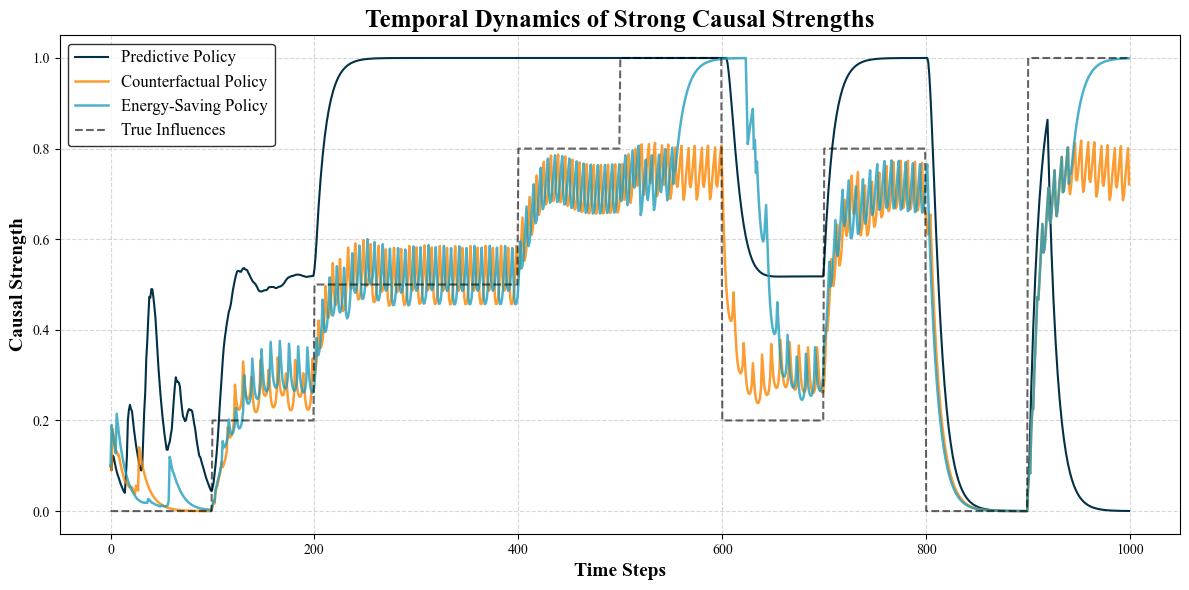

In [1171]:
result_counterfactual_strong = simulate_causal_agent(
            n_samples=n_samples,
            causal_influences=causal_influences_strong,
            network=hgf_causal,
            decision_function=counterfactual_policy,
        )
result_energy_strong = simulate_causal_agent(
            n_samples=n_samples,
            causal_influences=causal_influences_strong,
            network=hgf_causal,
            decision_function=energy_saving_policy,
        )

result_predictive_strong = simulate_causal_agent(
            n_samples=n_samples,
            causal_influences=causal_influences_strong,
            network=hgf_causal,
            decision_function=predictive_causal_policy,
        )

# aestatitcs
rcParams['font.family'] = 'Times New Roman'
colors = ["#FB8500", "#219EBC", "#023047", "#FFB703", "#8ECAE6"]

plt.figure(figsize=(12, 6))
plt.plot(result_predictive_strong['causal_strengths'], label='Predictive Policy', color=colors[2], linewidth=1.5)
plt.plot(result_counterfactual_strong['causal_strengths'], label='Counterfactual Policy', color=colors[0], linewidth=1.8, alpha=0.8)
plt.plot(result_energy_strong['causal_strengths'], label='Energy-Saving Policy', color=colors[1], linewidth=1.8, alpha=0.8)
plt.plot(causal_influences_strong, label='True Influences', color='black', linestyle='--', linewidth=1.5, alpha=0.6)

# Add a bold title with larger font size
plt.title("Temporal Dynamics of Strong Causal Strengths", fontsize=18, weight='bold')

# Add axis labels with a slightly larger font size
plt.xlabel("Time Steps", fontsize=14, weight='bold')
plt.ylabel("Causal Strength", fontsize=14, weight='bold')

# Customize the legend
plt.legend(fontsize=12, frameon=True, loc='best', edgecolor='black')

# Add gridlines with a higher alpha for better visibility
plt.grid(alpha=0.5, linestyle='--')

# Use tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


0.0 -0.05508277948244575
-0.0 -0.21583789907291126
0.0 -0.48683677745170295
0.0 -0.35576171992054273
0.0 0.0492648551663879
0.0 -0.4014829626825479
0.0 -1.1125252841315647
0.0 -1.1514852118525407
0.0 -1.4758598308446889
0.0 -2.3260772616611995
0.0 -2.83989594659848
0.0 -3.5735575555626875
0.0 -3.274574318797879
0.0 -3.6513972608201444
0.0 -4.238530172311932
0.0 -3.353168417538759
0.0 -2.052889235866219
0.0 -2.8666227872397467
0.0 -2.334380952284625
0.0 -2.3560459123598534
0.0 -2.190873112319337
0.0 -1.425736332310446
0.0 -1.8524951311964024
0.0 -1.485491650290729
0.0 -0.8426263775894111
0.0 -1.0667476668000928
0.0 0.2924657840447564
0.0 0.3416653967666439
0.0 0.7367836115958908
0.0 0.4187520216793692
0.0 -0.8145858961223036
0.0 -0.6602731510091951
0.0 -0.8923253463013276
0.0 -0.8155004016571942
0.0 -1.1307771253445686
0.0 -0.714495426007671
0.0 -0.7500136377790512
0.0 -1.724609862298498
0.0 -2.2283355189039207
0.0 -2.424509400899862
0.0 -2.957011210042539
0.0 -3.7151470908315165
0.0 -4

/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_33453/1564756170.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


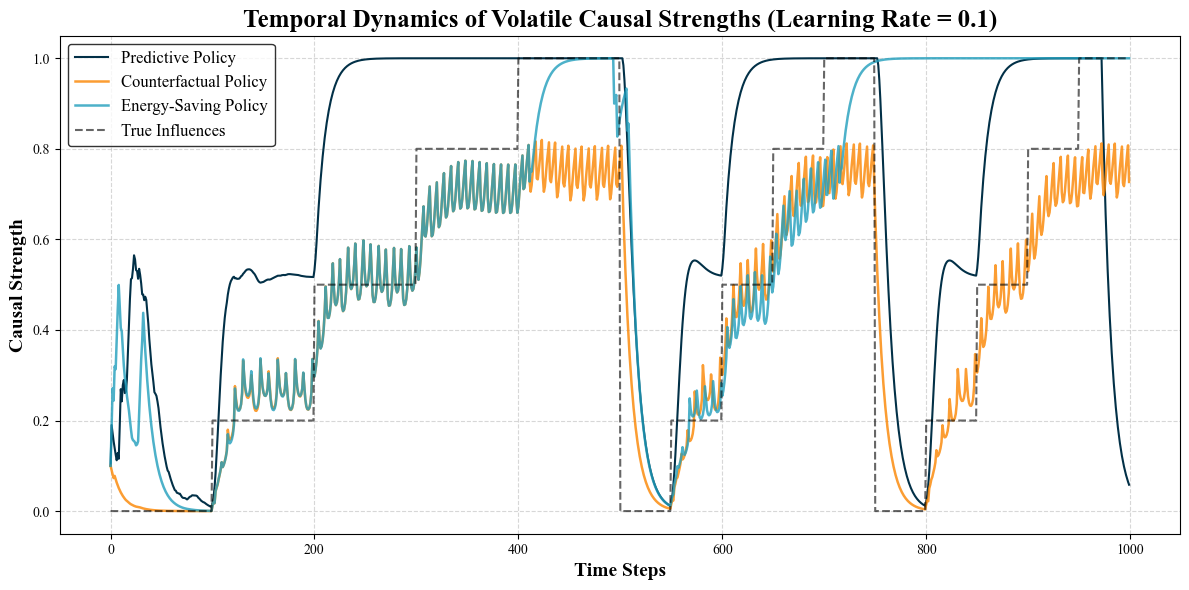

In [1172]:
result_counterfactual_shift = simulate_causal_agent(
            n_samples=n_samples,
            causal_influences=causal_influences_shift,
            network=hgf_causal,
            decision_function=counterfactual_policy,
        )
result_energy_shift = simulate_causal_agent(
            n_samples=n_samples,
            causal_influences=causal_influences_shift,
            network=hgf_causal,
            decision_function=energy_saving_policy,
        )

result_predictive_shift = simulate_causal_agent(
            n_samples=n_samples,
            causal_influences=causal_influences_shift,
            network=hgf_causal,
            decision_function=predictive_causal_policy,
        )

# Plotting - Shifted Causal Strengths
plt.figure(figsize=(12, 6))
plt.plot(result_predictive_shift['causal_strengths'], label='Predictive Policy', color=colors[2], linewidth=1.5)
plt.plot(result_counterfactual_shift['causal_strengths'], label='Counterfactual Policy', color=colors[0], linewidth=1.8, alpha=0.8)
plt.plot(result_energy_shift['causal_strengths'], label='Energy-Saving Policy', color=colors[1], linewidth=1.8, alpha=0.8)
plt.plot(causal_influences_shift, label='True Influences', color='black', linestyle='--', linewidth=1.5, alpha=0.6)

# Add a bold title with larger font size
plt.title("Temporal Dynamics of Volatile Causal Strengths (Learning Rate = 0.1)", fontsize=18, weight='bold')

# Add axis labels with a slightly larger font size
plt.xlabel("Time Steps", fontsize=14, weight='bold')
plt.ylabel("Causal Strength", fontsize=14, weight='bold')

# Customize the legend
plt.legend(fontsize=12, frameon=True, loc='best', edgecolor='black')

# Add gridlines with a higher alpha for better visibility
plt.grid(alpha=0.5, linestyle='--')

# Use tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


0.0 -0.3466632523310889
-0.0 0.495945340065763
0.0 0.5727322035313677
-0.0 0.31845889093209484
-0.0 0.28526303719870644
-0.0 0.32041106049541784
-0.0 0.8657908875307088
-0.0 0.36492805021773655
-0.0 0.1126266886729545
-0.0 0.4900655655831561
-0.0 0.484138822617206
-0.0 0.04256621108404052
-0.0 -0.5359776777735255
-0.0 -1.1137425068727063
-0.0 -0.8603748232544702
0.0 0.07212427426722468
0.0 -0.9678255570619184
0.0 -1.5230696224628155
0.0 -0.908154575421051
0.0 -0.9630684279301491
0.0 -0.16815737065490988
0.0 0.3138692325948933
0.0 0.09008088192940858
0.0 0.7896259364290729
0.0 0.6075008624251348
0.0 0.6049122292451222
0.0 1.389766833468914
-0.0 1.6463000762545439
-0.0 1.8006169566914725
-0.0 2.2204830177400083
-0.0 1.7064576515051775
-0.0 1.814079235739979
-0.0 2.094887912765943
-0.0 1.217457590721588
-0.0 1.1817508000868135
-0.0 0.6177614994378838
-0.0 0.41284965487768693
-0.0 -0.09252913878855223
-0.0 0.8885163112842971
-0.0 0.9196592104971326
-0.0 0.4878287506718019
-0.0 0.6979001889

/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_33453/278518195.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


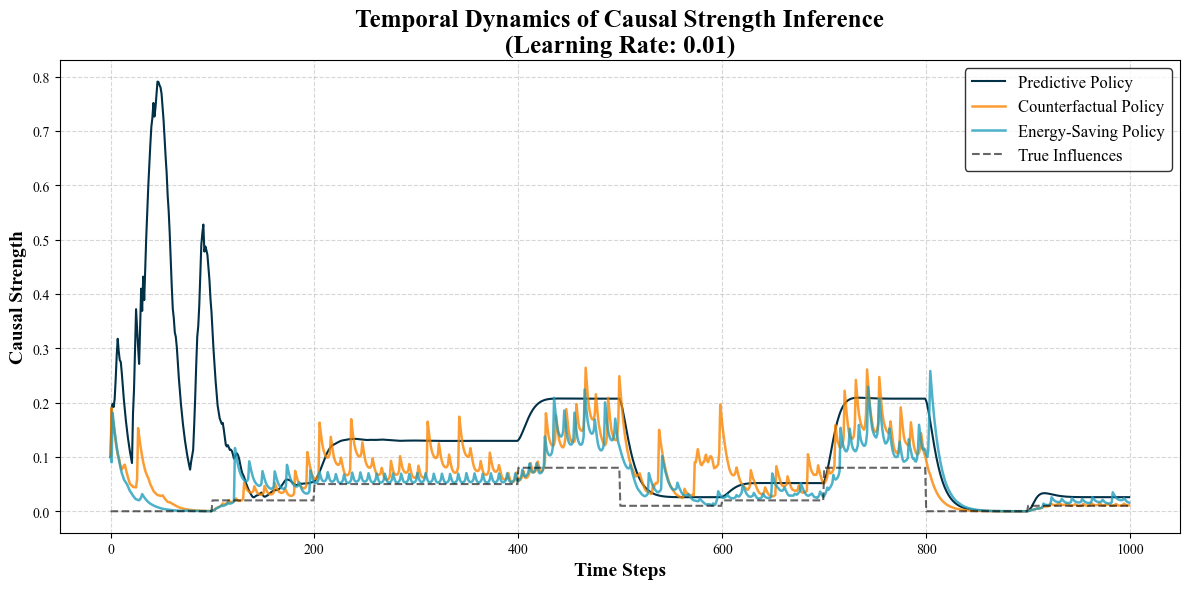

In [1173]:
## here,the learning rate should be FROM 0.1 TO 0.01

result_counterfactual = simulate_causal_agent(
            n_samples=n_samples,
            causal_influences=causal_influences,
            network=hgf_causal,
            decision_function=counterfactual_policy,
        )
result_energy = simulate_causal_agent(
            n_samples=n_samples,
            causal_influences=causal_influences,
            network=hgf_causal,
            decision_function=energy_saving_policy,
        )

result_predictive = simulate_causal_agent(
            n_samples=n_samples,
            causal_influences=causal_influences,
            network=hgf_causal,
            decision_function=predictive_causal_policy,
        )


# Example of enhancing the plot
plt.figure(figsize=(12, 6))
plt.plot(result_predictive['causal_strengths'], label='Predictive Policy', color=colors[2], linewidth=1.5)
plt.plot(result_counterfactual['causal_strengths'], label='Counterfactual Policy', color=colors[0], linewidth=1.8, alpha=0.8)
plt.plot(result_energy['causal_strengths'], label='Energy-Saving Policy', color=colors[1], linewidth=1.8, alpha=0.8)
plt.plot(causal_influences, label='True Influences', color='black', linestyle='--', linewidth=1.5, alpha=0.6)

# Add a bold title with larger font size
plt.title("Temporal Dynamics of Causal Strength Inference\n(Learning Rate: 0.01)", fontsize=18, weight='bold')

# Add axis labels with a slightly larger font size
plt.xlabel("Time Steps", fontsize=14, weight='bold')
plt.ylabel("Causal Strength", fontsize=14, weight='bold')

# Customize the legend
plt.legend(fontsize=12, frameon=True, loc='best', edgecolor='black')

# Add gridlines with a higher alpha for better visibility
plt.grid(alpha=0.5, linestyle='--')

# Use tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


### Plotting the results

In [1174]:
## What plots do we want? 
## boxplots for each policy as well as the non causal HGF: 
# 1. cumulative surprise over whole run timeseries 
# 2. cumulative deviations from 0 
# 3. cumulative actions (how much energy had to be used)
## for the three causal graph policies: 
# deviations of infered causal strength from true causal strength 

/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_33453/1282017833.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


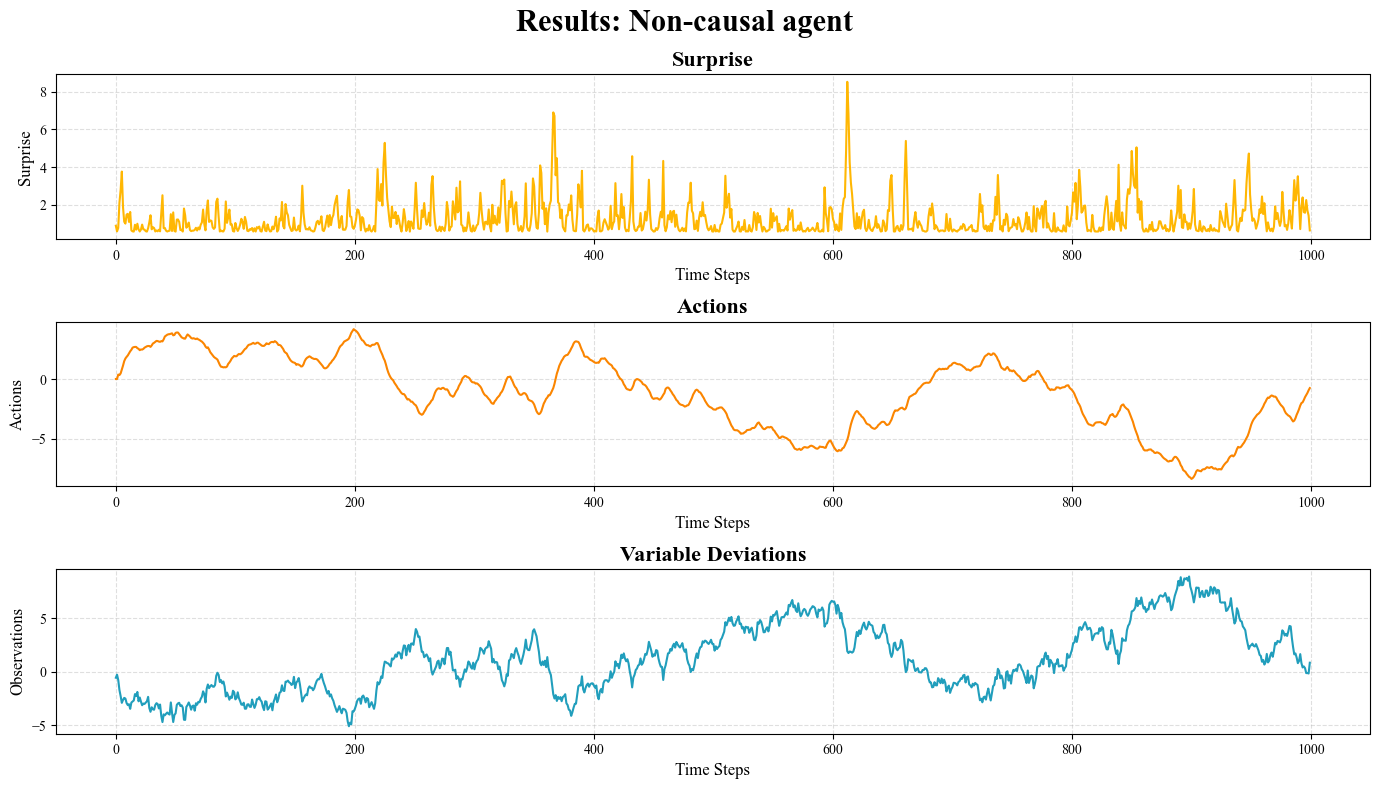

In [1175]:
# Plotting - Non-Causal Results (Surprise, Actions, Observations)
fig = plt.figure(figsize=(14, 8))
fig.suptitle('Results: Non-causal agent', fontsize=22, weight='bold')

# Plot surprise
plt.subplot(3, 1, 1)
plt.plot(non_causal_results['surprise'], label='Surprise', color=colors[3], linewidth=1.5)
plt.title("Surprise", fontsize=16, weight='bold')
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Surprise", fontsize=12)
plt.grid(alpha=0.4, linestyle='--')

# Plot actions
plt.subplot(3, 1, 2)
plt.plot(non_causal_results['actions'], label='Actions', color=colors[0], linewidth=1.5)
plt.title("Actions", fontsize=16, weight='bold')
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Actions", fontsize=12)
plt.grid(alpha=0.4, linestyle='--')

# Plot observations
plt.subplot(3, 1, 3)
plt.plot(non_causal_results['observations'], label='Observations', color=colors[1], linewidth=1.5)
plt.title("Variable Deviations", fontsize=16, weight='bold')
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Observations", fontsize=12)
plt.grid(alpha=0.4, linestyle='--')

# Use tight layout for all subplots
plt.tight_layout()

# Display the combined plot
plt.show()

/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_33453/2561336574.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


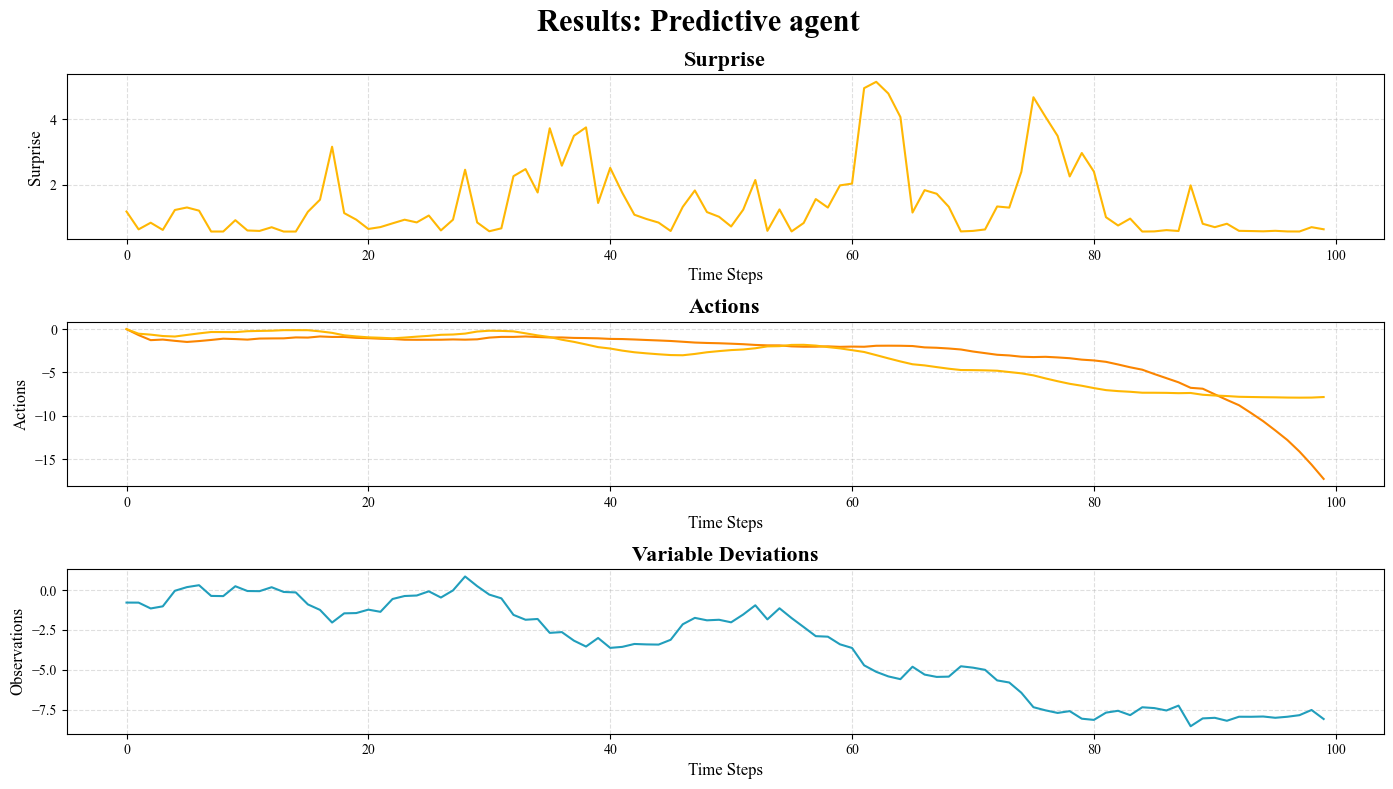

In [1176]:
# Plotting - Non-Causal Results (Surprise, Actions, Observations)
fig = plt.figure(figsize=(14, 8))
fig.suptitle('Results: Predictive agent', fontsize=22, weight='bold')

# Plot surprise
plt.subplot(3, 1, 1)
plt.plot(result_predictive_strong['surprise'][00:100], label='Surprise', color=colors[3], linewidth=1.5)
plt.title("Surprise", fontsize=16, weight='bold')
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Surprise", fontsize=12)
plt.grid(alpha=0.4, linestyle='--')

# Plot actions
plt.subplot(3, 1, 2)
plt.plot(result_predictive_strong['actions'][00:100], label='Actions', color=colors[0], linewidth=1.5)
plt.plot(result_predictive_strong['node_1_expected_mean'][00:100], label='Actions', color=colors[3], linewidth=1.5)
plt.title("Actions", fontsize=16, weight='bold')
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Actions", fontsize=12)
plt.grid(alpha=0.4, linestyle='--')

# Plot observations
plt.subplot(3, 1, 3)
plt.plot(result_predictive_strong['observations'][00:100], label='Observations', color=colors[1], linewidth=1.5)
plt.title("Variable Deviations", fontsize=16, weight='bold')
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Observations", fontsize=12)
plt.grid(alpha=0.4, linestyle='--')

# Use tight layout for all subplots
plt.tight_layout()

# Display the combined plot
plt.show()

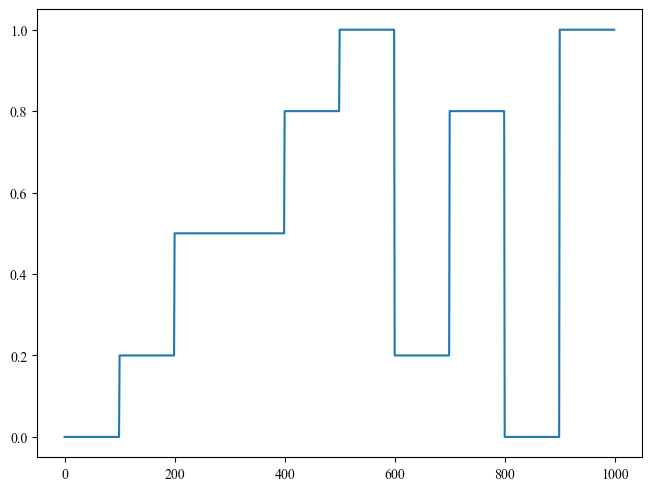

In [1177]:
sum(result_predictive['surprise'])
sum(non_causal_results['surprise'])
plt.plot(causal_influences_strong)

## System configuration

In [1178]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Dec 18 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pyhgf : 0.0.0
jax   : 0.4.35
jaxlib: 0.4.35

sklearn   : 1.5.1
matplotlib: 3.9.2
sys       : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
IPython   : 8.29.0
pandas    : 2.2.3
pyhgf     : 0.0.0
numpy     : 1.26.4
seaborn   : 0.13.2
jax       : 0.4.35

Watermark: 2.5.0

